In [36]:
import tensorflow as tf
# print('import tf', tf.__version__)

import os,pickle
import time
import datetime
from imp import reload
from matplotlib import pyplot as plt
import numpy as np
from sys import stdout
from units.globals import DEBUG

print('import module')
os.system('pwd')

import GAN2_tot
from GAN2_tot.dataloader import load_pair,load_image_train,load_image_test
from GAN2_tot.prep import random_jitter
from GAN2_tot.model import Generator,Discriminator
from GAN2_tot.loss import get_gen_loss,get_disc_loss

from units.base import visualize,generate_images,show
from sklearn.model_selection import train_test_split

import module


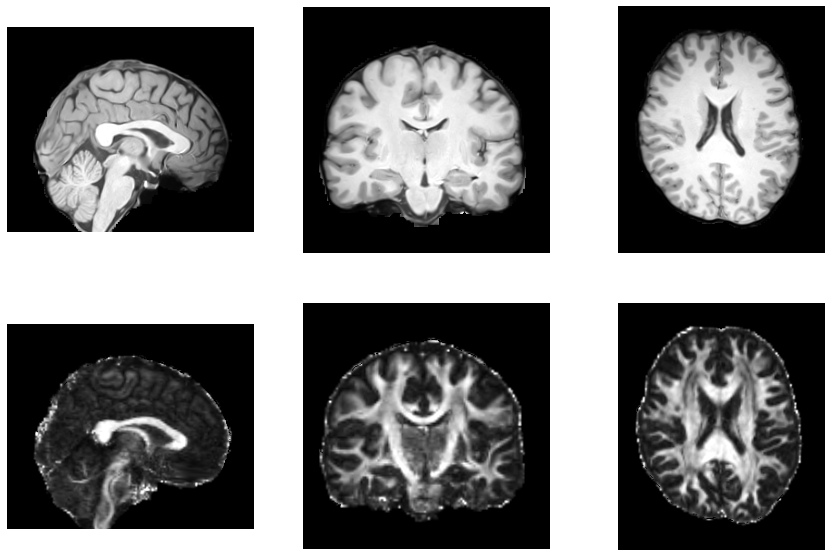

In [37]:
NEWPATH="datasets/brainmap/npdata"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
demo=np.load(data[0])
t1,fa=demo[0],demo[1]
mask=(t1!=0)&(fa!=0)
t1*=mask
fa*=mask
# t1[fa==0]=0
visualize([t1,fa],save_path="demo/paired.png")

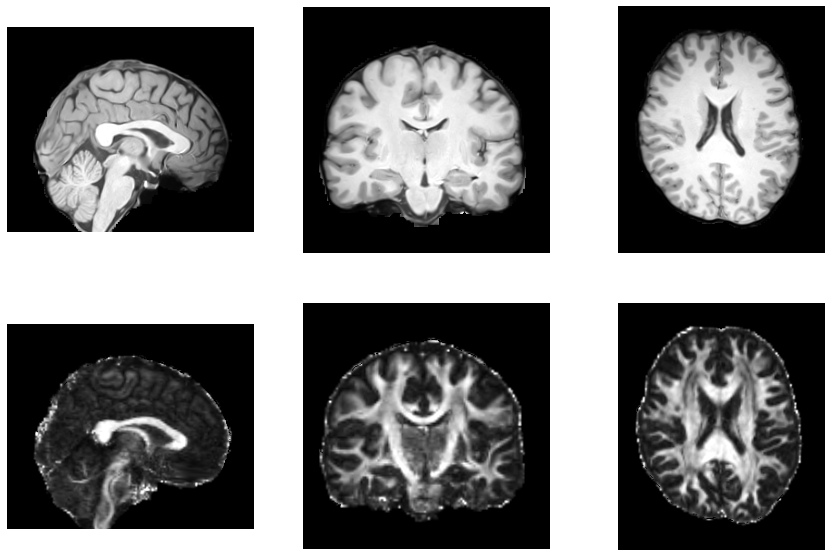

In [38]:
### visualize argument
# reload(GAN2_tot.prep)
from GAN2_tot.prep import random_jitter

# for i in range(1):
st_range=np.array((227, 272, 227))-np.array((128,128,128))

def load_demo(data):
    st=np.random.randint(st_range)
    ed=st+128
    # x,y=data[0][st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]],data[1][st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]]
    x,y=data[0],data[1]
    return x,y
t1_arg,fa_arg=load_demo([t1,fa])#Patch_extration()(t1,fa)
# t1_arg,fa_arg=load_image_train(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
visualize([t1_arg,fa_arg])
np.save("demo/t1_arg",t1_arg)
np.save("demo/fa_arg",fa_arg)

In [5]:
NEWPATH="datasets/brainmap/npdata"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
show(f"Train len: {len(train)}")
show(f"Val len: {len(val)}")
show(f"Test len: {len(test)}")

Train len: 16
Val len: 2
Test len: 2


In [6]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 4
st_range=np.array((227, 272, 227))-np.array((128,128,128))
def load_np_data(filename):
    if type(filename)!=str:
        filename=filename.decode()
    data=np.load(filename,mmap_mode="r")
        # tf.random.
    st=np.random.randint(st_range)
    ed=st+128
    # x,y=data[0,st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]],data[1,st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]]
    x,y=data[0],data[1]
    mask=(x!=0)&(y!=0)
    return tf.convert_to_tensor(x*mask),tf.convert_to_tensor(y*mask)
        
warp_load_np=lambda x:tf.numpy_function(func=load_np_data,inp=[x],Tout=(tf.float32,tf.float32))

def get_train_ds(train):
    # train_dataset=[]
    # for t in tqdm(train):
        # train_dataset.append(load_image_train(t))
    # train_dataset=np.array(train_dataset)
    # train_dataset = list(map(load_image_train,train))
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train)
    # print(train_dataset)
    # train_dataset=load_image_train(train)
    train_dataset = train_dataset.map(map_func=warp_load_np,num_parallel_calls=8)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE,seed=114514)
    train_dataset = train_dataset.batch(BATCH_SIZE,num_parallel_calls=8)
    return train_dataset
# train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))

def get_test_ds(test):
    # test_dataset=[]
    # for i in range(8):test_dataset+=[load_image_test(test_dir)for test_dir in test]
    # iplist,relist=[],[]
    # for input,real in test_dataset:
    #     iplist.append(input)
    #     relist.append(real)
    test_dataset = tf.data.Dataset.from_tensor_slices(test)
    test_dataset = test_dataset.map(map_func=warp_load_np,num_parallel_calls=8)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=16,deterministic=False)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    test_dataset = test_dataset.batch(BATCH_SIZE,num_parallel_calls=8)
    return test_dataset

train_ds,val_ds,test_ds=get_train_ds(train),get_test_ds(val),get_test_ds(test)

In [3]:
# del Generator
reload(GAN2_tot)
import GAN2_tot
from GAN2_tot.model import Generator,Discriminator
# tip,fip=t1_arg[tf.newaxis, ...],fa_arg[tf.newaxis, ...]
tg=Generator()
ds=Discriminator()
tf.keras.utils.plot_model(tg, show_shapes=True, dpi=100)

gen_output = tg(tip, training=False)
# print(gen_output.shape)
generate_images(tg,tip,fip)


disc_output = ds([tip,fip], training=False)
# print(gen_output.shape)
# visualize(tip[0,:,:,:])
visualize(disc_output[0,...,0])


NameError: name 'tip' is not defined

In [30]:
gen_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

from GAN2_tot.model import Generator,Discriminator
# reload(GAN2_tot.model)
generator = Generator()
discriminator=Discriminator()
from GAN2_tot.loss import get_gen_loss,get_disc_loss
# reload(GAN.loss)


In [20]:
log_dir="logs/"
this_log_dir=log_dir + "GAN_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(this_log_dir)
path=f"{this_log_dir}/T1_FA"
checkpoint_dir = f"{this_log_dir}/training_checkpoints"
checkpoint_prefix = checkpoint_dir+"/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_oper,
                                 discriminator_optimizer=disc_oper,
                                 generator=generator,
                                 discriminator=discriminator)


In [31]:
ALPHA=5
G,D=generator,discriminator
@tf.function
def train_step(img, tar, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        tar_fake = G(img, training=True)

        disc_real_output = D([img, tar], training=True)
        disc_fake_output = D([img, tar_fake], training=True)

        gen_loss, dice_loss, gan_disc_loss = get_gen_loss(
            tar,tar_fake,disc_fake_output, ALPHA)
        disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_grad = gen_tape.gradient(
        gen_loss, G.trainable_variables)
    disc_grad = disc_tape.gradient(
        disc_loss, D.trainable_variables)

    gen_oper.apply_gradients(
        zip(gen_grad, G.trainable_variables))
    disc_oper.apply_gradients(
        zip(disc_grad, D.trainable_variables))

    
    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step)
        tf.summary.scalar('dice_loss', dice_loss, step)
        tf.summary.scalar('gan_disc_loss', gan_disc_loss,step)
        tf.summary.scalar('disc_loss', disc_loss,step)
    return gen_loss, dice_loss, gan_disc_loss, disc_loss

In [32]:
@tf.function
def test_step(img, tar):
    tar_fake = G(img, training=False)

    disc_real_output = D([img, tar], training=False)
    disc_fake_output = D([img, tar_fake], training=False)
    disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_loss, dice_loss, gan_disc_loss = get_gen_loss(tar, tar_fake, disc_fake_output, ALPHA)
        
    return gen_loss, dice_loss, gan_disc_loss, disc_loss

In [42]:
val_time=len(train_ds)//BATCH_SIZE*5
tot_step=len(train_ds)*500

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    history = {'train': [], 'valid': []}
    prev_loss = np.inf

    train_losses=[tf.keras.metrics.Mean() for i in range(4)]
    test_losses=[tf.keras.metrics.Mean() for i in range(4)]

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():

        start = time.time()
        show(f'Epoch {step+1}/{steps}')

        # if (step+1) % 1 == 0:
            # display.clear_output(wait=True)
            # generate_images(generator, example_input, example_target)

        train_step_loss=train_step(input_image, target, step)
        for meti,li in zip(train_losses,train_step_loss):meti.update_state(li)
        gen_loss, dice_loss, gan_disc_loss, disc_loss=[x.result() for x in train_losses]

        show(f'\rStep: {step+1}/{steps} - loss: {gen_loss:.6f} - dice_loss: {dice_loss:.6f} - gan_disc_loss: {gan_disc_loss:.6f} - disc_loss: {disc_loss:.6f}')
        
        show(f'Time taken for 1 steps: {time.time()-start:.2f} sec\n')
        
        if (step+1) % val_time==0:
            
            for val_step, (input_image, target) in test_ds.enumerate():
                test_step_loss=test_step(input_image, target)
                for meti,li in zip(test_losses,test_step_loss):meti.update_state(li)
            
            gen_loss_val, dice_loss_val, gan_disc_loss_val, disc_loss_val=[x.result() for x in test_losses]
            show(f'\rVal_step: {(step+1)//val_time}/{steps//val_time} - val_loss: {gen_loss_val:.6f} - val_dice_loss: {dice_loss_val:.6f} - val_gan_disc_loss: {gan_disc_loss_val:.6f} - val_disc_loss: {disc_loss_val:.6f}')


            save_path=f"{path}/step_{step+1:03d}"
            os.makedirs(save_path,exist_ok=True)
            
            generate_images(G,example_input, example_target,save_path=f"{save_path}/show.png")
            G.save(f"{save_path}/G.h5") 
            D.save(f"{save_path}/D.h5") 

            if gen_loss_val < prev_loss:    
                G.save(f"{path}/Generator.h5") 
                D.save(f"{path}/Discriminator.h5") 
                show(f"Validation loss decresaed from {prev_loss:.4f} to {gen_loss_val:.4f}. Models' weights are now saved.")
                prev_loss=gen_loss_val
            else:
                show(f"Validation loss did not decrese from {prev_loss:.4f} to {gen_loss_val:.4f}.")

            history['train'].append([x.result().numpy() for x in train_losses])
            history['valid'].append([x.result().numpy() for x in test_losses])
            for x in train_losses:x.reset_states()
            for x in test_losses:x.reset_states()
            checkpoint.save(file_prefix=checkpoint_prefix)
    return history


Epoch 1/1
Step: 1/1 - loss: 33.072296 - dice_loss: 6.321372 - gan_disc_loss: 1.465441 - disc_loss: 1.162576Time taken for 1 steps: 37.45 sec

Val_step: 1/1 - val_loss: 21.818893 - val_dice_loss: 4.043412 - val_gan_disc_loss: 1.601834 - val_disc_loss: 1.607530

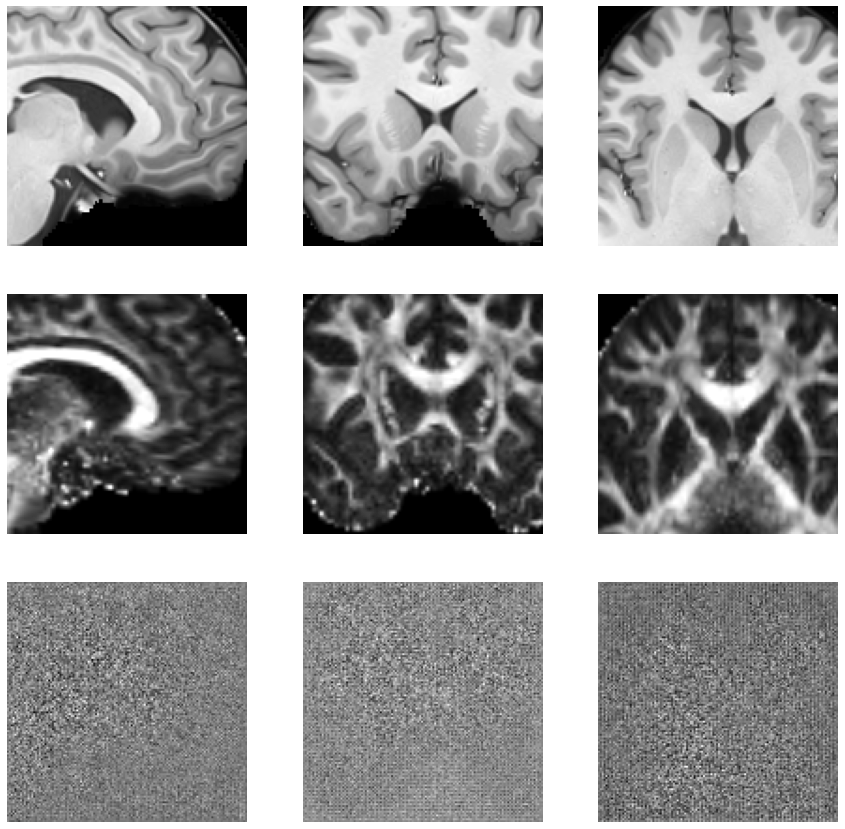

Validation loss decresaed from inf to 21.8189. Models' weights are now saved.


TypeError: file must have a 'write' attribute

In [39]:
h=fit(train_ds,val_ds,steps=tot_step)
with open(f"{this_log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)

In [44]:
with open(f"{this_log_dir}/training_log.pic","rb") as f:
    t=pickle.load(f)

{'train': [[33.072296, 6.3213716, 1.4654408, 1.1625764]],
 'valid': [[21.818893, 4.043412, 1.6018337, 1.6075299]]}

In [ ]:
#try tensor.map
train_dataset = tf.data.Dataset.from_tensor_slices(train)
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
    return t.decode('utf-8')+"1",t.decode('utf-8')+"2"
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
        #   inp=[x], Tout=tf.string))
# list(d.as_numpy_iterator())
train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))
# train_dataset=train_dataset.map(lambda x:tf.strings.as_string(x)+"2")
list(train_dataset.as_numpy_iterator())
# len(train_dataset.map(np.array))
# for i in train_dataset:
    # print()#.numpy())


In [ ]:
from numpy.random import randint
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return (t.decode('utf-8')+str(randint(10))).upper()
d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
          inp=[x], Tout=tf.string),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
list(d.repeat().take(10).as_numpy_iterator())
# list(d.as_numpy_iterator())

[b'HELLO3',
 b'WORLD3',
 b'HELLO9',
 b'WORLD2',
 b'HELLO9',
 b'WORLD5',
 b'HELLO4',
 b'WORLD2',
 b'HELLO8',
 b'WORLD2']

In [ ]:
class A:
    def __init__(self):
        self.t=10
    def exec(self,b):
        self.t+=b
a=[A()for i in range(4)]
b=[i for i in range(4)]
map(lambda x,y:x.exec(y),a,b)
a[2].t

12

In [4]:
try_G=Generator()
# try_G.load_weights("logs/GAN_fit/tryresult/G.h5")
try_G.load_weights(r"GAN\saved_weights\G.h5")

In [15]:
t1_256,fa_256=np.zeros((1,256,256,256)),np.zeros((1,256,256,256))
t1_256[0,:227,:256,:227]=t1[:,:256,:]
fa_256[0,:227,:256,:227]=fa[:,:256,:]
fa_fake=try_G(t1_256)[0,...,0]

# visualize([t1_256[0,...],fa_256[0,...],fa_fake[0,...,0],fa_fake-fa_256])

In [20]:
from GAN2_tot.prep import normalize
# fat.shape

(256, 256, 256)

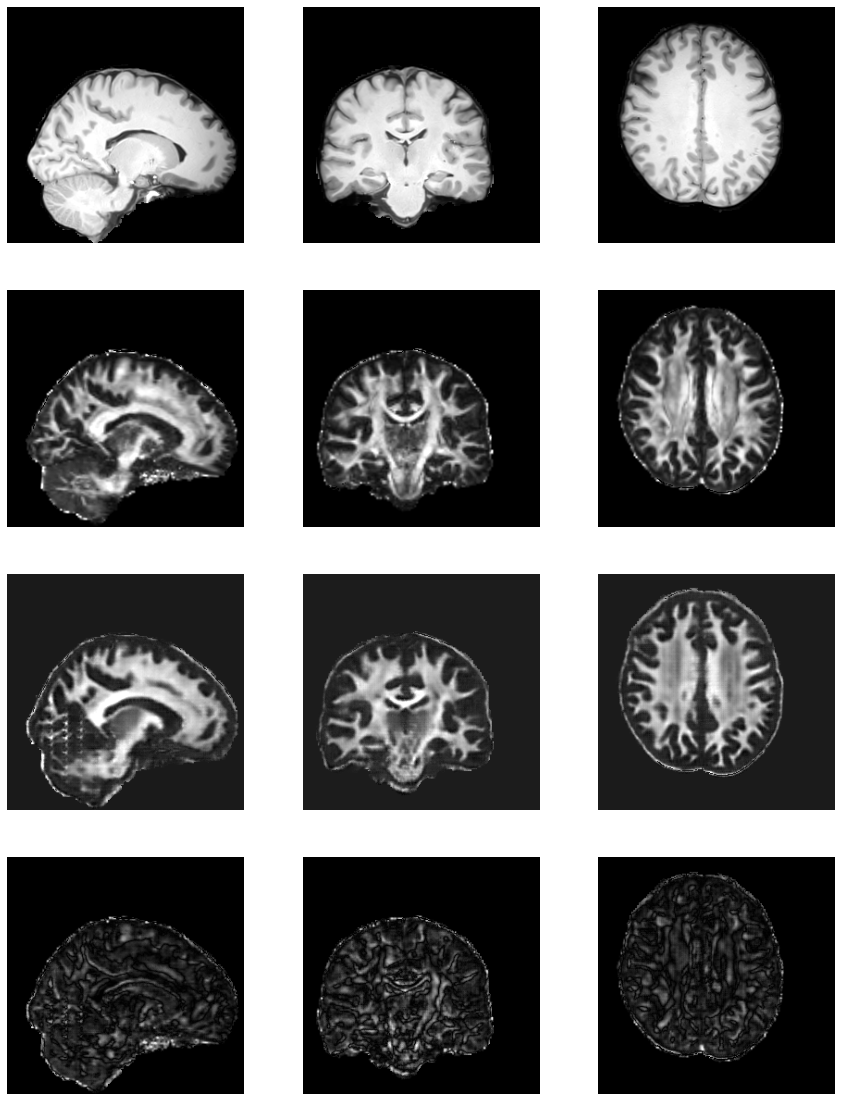

1.0855430960655212 1.0 0.9950310587882996


In [28]:
fat=fa_fake.numpy()
fat[t1_256[0,...]==0]=0
fat=normalize(fat)
delta_FA=abs(fat-fa_256[0,...])
visualize([t1_256[0,...],fa_256[0,...],fat,delta_FA])
print(delta_FA.max(),fat.max(),fa_256.max())

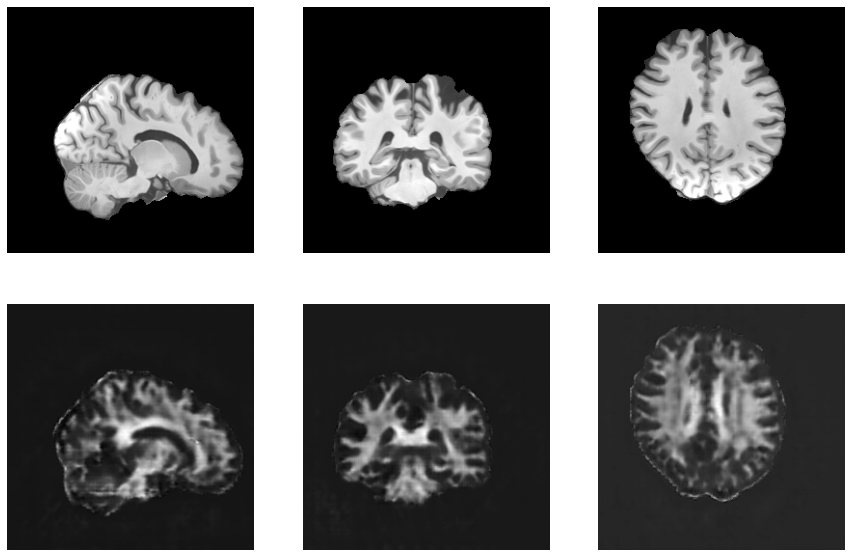

In [34]:
t1,fa_fake=np.load(r"C:\Users\CH2\Documents\datasets\adData_Huashan\MCI_MLL\t1.npy"),np.load(r"C:\Users\CH2\Documents\datasets\adData_Huashan\MCI_MLL\fa_fake_256.npy")
t1_256=np.zeros((256,256,256))
t1_256[:227,:256,:227]=t1[:,:256,:]
visualize([t1_256,fa_fake])

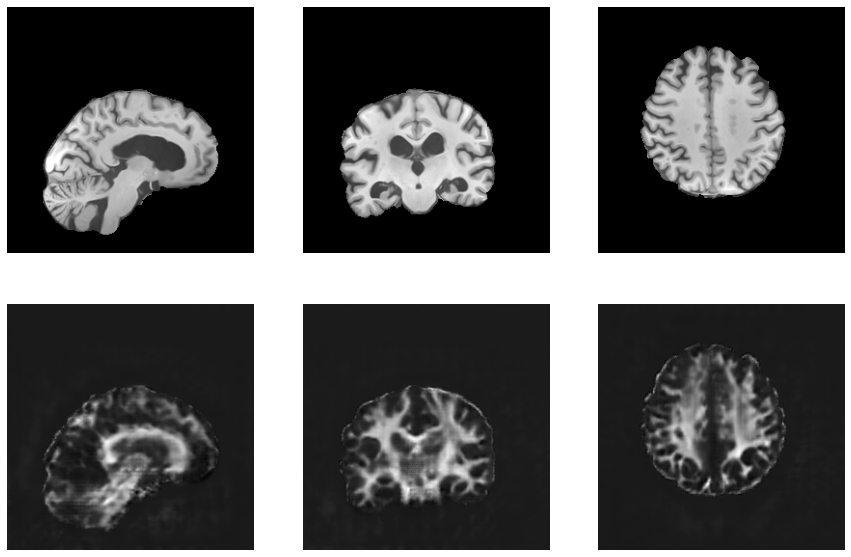

In [35]:
t1,fa_fake=np.load(r"C:\Users\CH2\Documents\datasets\adData_Huashan\D_GXY\t1.npy"),np.load(r"C:\Users\CH2\Documents\datasets\adData_Huashan\D_GXY\fa_fake_256.npy")
t1_256=np.zeros((256,256,256))
t1_256[:227,:256,:227]=t1[:,:256,:]
visualize([t1_256,fa_fake])